In [19]:
!pip install qiskit qiskit-aer --quiet
!pip install qiskit-aer

In [24]:
!pip install pylatexenc

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pylatexenc: filename=pylatexenc-2.10-py3-none-any.whl size=136817 sha256=df151ad450c5f1d115deb87d2c6d386bd355f7fd2e86a0124e70a25a70891f31
  Stored in directory: /root/.cache/pip/wheels/06/3e/78/fa1588c1ae991bbfd814af2bcac6cef7a178beee1939180d46
Successfully built pylatexenc


In [22]:
# ---Import Required Libraries (Qiskit ≥1.0) ---

from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error
import numpy as np
import matplotlib.pyplot as plt

In [25]:
# --- Task 1: Change the Phase Value θ (Qiskit ≥1.0 compatible) ---

# Step 1: Import necessary modules
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# Step 2: Define inverse QFT
def inv_qft(qc, n):
    """Inverse QFT on first n qubits."""
    for j in range(n // 2):
        qc.swap(j, n - j - 1)
    for j in range(n):
        for m in range(j):
            qc.crz(-np.pi / (2 ** (j - m)), m, j)
        qc.h(j)

# Step 3: Define the QPE circuit generator
def qpe_circuit(theta, t_count=3):
    """
    Quantum Phase Estimation circuit for a given phase θ.
    Args:
        theta (float): Phase to estimate, between 0 and 1.
        t_count (int): Number of counting qubits.
    """
    qc = QuantumCircuit(t_count + 1, t_count)

    # 1️⃣ Create superposition on counting qubits
    for q in range(t_count):
        qc.h(q)

    # 2️⃣ Prepare target qubit in |1⟩ (eigenstate)
    qc.x(t_count)

    # 3️⃣ Apply controlled-U^(2^j) gates — here a CRZ rotation encodes the phase
    for j in range(t_count):
        angle = 2 * np.pi * theta * (2 ** j)
        qc.crz(angle, j, t_count)

    # 4️⃣ Apply inverse QFT on counting register
    inv_qft(qc, t_count)

    # 5️⃣ Measure counting qubits
    qc.barrier()
    qc.measure(range(t_count), range(t_count))
    return qc

# Step 4: Try different θ values
thetas = [0.25, 0.375, 0.5]

for theta in thetas:
    qc = qpe_circuit(theta, t_count=3)
    print(f"--- QPE circuit for θ = {theta} ---")
    # Try to draw using mpl, fall back to text if pylatexenc is missing
    try:
        display(qc.draw('mpl'))
    except Exception:
        print(qc.draw('text'))

--- QPE circuit for θ = 0.25 ---
     ┌───┐                                 ┌───┐                             »
q_0: ┤ H ├─────■─────────────────────────X─┤ H ├─────■────────────────■──────»
     ├───┤     │                         │ └───┘┌────┴─────┐┌───┐     │      »
q_1: ┤ H ├─────┼─────────■───────────────┼──────┤ Rz(-π/2) ├┤ H ├─────┼──────»
     ├───┤     │         │               │      └──────────┘└───┘┌────┴─────┐»
q_2: ┤ H ├─────┼─────────┼────────■──────X───────────────────────┤ Rz(-π/4) ├»
     ├───┤┌────┴────┐┌───┴───┐┌───┴────┐                         └──────────┘»
q_3: ┤ X ├┤ Rz(π/2) ├┤ Rz(π) ├┤ Rz(2π) ├─────────────────────────────────────»
     └───┘└─────────┘└───────┘└────────┘                                     »
c: 3/════════════════════════════════════════════════════════════════════════»
                                                                             »
«                       ░ ┌─┐      
«q_0: ──────────────────░─┤M├──────
«                       ░ 

In [26]:
# --- Task 2: Increase Number of Counting Qubits (Qiskit ≥1.0 compatible) ---

from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# --- Reuse the inverse QFT from Task 1 ---
def inv_qft(qc, n):
    for j in range(n // 2):
        qc.swap(j, n - j - 1)
    for j in range(n):
        for m in range(j):
            qc.crz(-np.pi / (2 ** (j - m)), m, j)
        qc.h(j)

# --- Reuse QPE circuit function but allow variable counting qubits ---
def qpe_circuit(theta, t_count):
    qc = QuantumCircuit(t_count + 1, t_count)

    # Create superposition on counting qubits
    for q in range(t_count):
        qc.h(q)

    # Prepare target qubit in |1⟩
    qc.x(t_count)

    # Controlled phase rotations
    for j in range(t_count):
        angle = 2 * np.pi * theta * (2 ** j)
        qc.crz(angle, j, t_count)

    # Apply inverse QFT
    inv_qft(qc, t_count)

    # Measure
    qc.barrier()
    qc.measure(range(t_count), range(t_count))
    return qc

# --- Simulate with 4 and 5 counting qubits ---
simulator = AerSimulator()

theta = 0.375   # fixed phase value for comparison
t_counts = [4, 5]

for t in t_counts:
    qc = qpe_circuit(theta, t)
    print(f"--- QPE with {t} counting qubits ---")

    # Visualize circuit (safe fallback if pylatexenc missing)
    try:
        display(qc.draw('mpl'))
    except Exception:
        print(qc.draw('text'))

    # Execute simulation
    compiled = transpile(qc, simulator)
    job = simulator.run(compiled, shots=2048)
    result = job.result()
    counts = result.get_counts()

    # Plot histogram
    plot_histogram(counts, title=f"θ = {theta}, counting qubits = {t}")
    plt.show()

--- QPE with 4 counting qubits ---
     ┌───┐                                               ┌───┐                 »
q_0: ┤ H ├─────■───────────────────────────────────────X─┤ H ├─────■───────────»
     ├───┤     │                                       │ └───┘┌────┴─────┐┌───┐»
q_1: ┤ H ├─────┼───────────■────────────────────X──────┼──────┤ Rz(-π/2) ├┤ H ├»
     ├───┤     │           │                    │      │      └──────────┘└───┘»
q_2: ┤ H ├─────┼───────────┼──────────■─────────X──────┼───────────────────────»
     ├───┤     │           │          │                │                       »
q_3: ┤ H ├─────┼───────────┼──────────┼─────────■──────X───────────────────────»
     ├───┤┌────┴─────┐┌────┴─────┐┌───┴────┐┌───┴────┐                         »
q_4: ┤ X ├┤ Rz(3π/4) ├┤ Rz(3π/2) ├┤ Rz(3π) ├┤ Rz(6π) ├─────────────────────────»
     └───┘└──────────┘└──────────┘└────────┘└────────┘                         »
c: 4/═════════════════════════════════════════════════════════════════════

In [27]:
# --- Task 3: Compare with Theoretical Output (Qiskit ≥1.0 compatible) ---

from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt
from qiskit import QuantumCircuit, transpile
from qiskit.visualization import plot_histogram

# --- Inverse QFT (reuse from earlier tasks) ---
def inv_qft(qc, n):
    for j in range(n // 2):
        qc.swap(j, n - j - 1)
    for j in range(n):
        for m in range(j):
            qc.crz(-np.pi / (2 ** (j - m)), m, j)
        qc.h(j)

# --- QPE circuit function (reuse) ---
def qpe_circuit(theta, t_count):
    qc = QuantumCircuit(t_count + 1, t_count)
    for q in range(t_count):
        qc.h(q)
    qc.x(t_count)
    for j in range(t_count):
        angle = 2 * np.pi * theta * (2 ** j)
        qc.crz(angle, j, t_count)
    inv_qft(qc, t_count)
    qc.barrier()
    qc.measure(range(t_count), range(t_count))
    return qc

# --- Step 1: Define parameters ---
theta = 0.375      # Example phase
t_count = 4        # Number of counting qubits
shots = 2048

# --- Step 2: Compute theoretical binary representation ---
binary_fraction = int(theta * (2 ** t_count))
expected_binary = format(binary_fraction, f"0{t_count}b")

print(f"Theoretical phase = {theta}")
print(f"Expected binary (4 qubits) = {expected_binary}")

# --- Step 3: Build and run the circuit ---
simulator = AerSimulator()
qc = qpe_circuit(theta, t_count)

compiled = transpile(qc, simulator)
job = simulator.run(compiled, shots=shots)
result = job.result()
counts = result.get_counts()

# --- Step 4: Plot histogram of measured results ---
plot_histogram(counts, title=f"Measured Results for θ={theta}")
plt.show()

# --- Step 5: Compare top result with theoretical expectation ---
measured_top = max(counts, key=counts.get)
print(f"\nMost frequent measured output: {measured_top}")
print(f"Expected (theoretical) output: {expected_binary}")

# --- Step 6: Interpret phase estimate ---
decimal_estimate = int(measured_top, 2) / (2 ** t_count)
print(f"Estimated θ from measurement = {decimal_estimate:.3f}")

Theoretical phase = 0.375
Expected binary (4 qubits) = 0110

Most frequent measured output: 0011
Expected (theoretical) output: 0110
Estimated θ from measurement = 0.188


In [28]:
# --- Task 4: Inverse QFT Visualization (Qiskit ≥1.0 compatible) ---

from qiskit import QuantumCircuit
from qiskit_aer import AerSimulator
import numpy as np
import matplotlib.pyplot as plt

# --- Define inverse QFT function (same as before) ---
def inv_qft(qc, n):
    """Applies the inverse QFT on the first n qubits."""
    for j in range(n // 2):
        qc.swap(j, n - j - 1)
    for j in range(n):
        for m in range(j):
            qc.crz(-np.pi / (2 ** (j - m)), m, j)
        qc.h(j)

# --- Define QPE circuit (up to inverse QFT, before measurement) ---
def qpe_circuit_before_measure(theta, t_count):
    qc = QuantumCircuit(t_count + 1, t_count)

    # Step 1: Superposition on counting qubits
    for q in range(t_count):
        qc.h(q)

    # Step 2: Prepare target |1⟩ state
    qc.x(t_count)

    # Step 3: Controlled phase rotations
    for j in range(t_count):
        angle = 2 * np.pi * theta * (2 ** j)
        qc.crz(angle, j, t_count)

    # Step 4: Apply inverse QFT (the part we want to visualize)
    inv_qft(qc, t_count)

    # ✅ Stop here before measurement to see QFT structure
    return qc

# --- Parameters ---
theta = 0.375
t_count = 4

qc_viz = qpe_circuit_before_measure(theta, t_count)

print(f"--- QPE Circuit (θ={theta}, {t_count} counting qubits) ---")
try:
    display(qc_viz.draw('mpl'))  # High-quality visualization
except Exception:
    print(qc_viz.draw('text'))   # Fallback if pylatexenc missing

# --- (Optional) Add measurement and visualize final circuit ---
qc_viz.barrier()
qc_viz.measure(range(t_count), range(t_count))

print("\n--- Full QPE Circuit with Measurement ---")
try:
    display(qc_viz.draw('mpl'))
except Exception:
    print(qc_viz.draw('text'))

--- QPE Circuit (θ=0.375, 4 counting qubits) ---
     ┌───┐                                               ┌───┐                 »
q_0: ┤ H ├─────■───────────────────────────────────────X─┤ H ├─────■───────────»
     ├───┤     │                                       │ └───┘┌────┴─────┐┌───┐»
q_1: ┤ H ├─────┼───────────■────────────────────X──────┼──────┤ Rz(-π/2) ├┤ H ├»
     ├───┤     │           │                    │      │      └──────────┘└───┘»
q_2: ┤ H ├─────┼───────────┼──────────■─────────X──────┼───────────────────────»
     ├───┤     │           │          │                │                       »
q_3: ┤ H ├─────┼───────────┼──────────┼─────────■──────X───────────────────────»
     ├───┤┌────┴─────┐┌────┴─────┐┌───┴────┐┌───┴────┐                         »
q_4: ┤ X ├┤ Rz(3π/4) ├┤ Rz(3π/2) ├┤ Rz(3π) ├┤ Rz(6π) ├─────────────────────────»
     └───┘└──────────┘└──────────┘└────────┘└────────┘                         »
c: 4/═══════════════════════════════════════════════════════

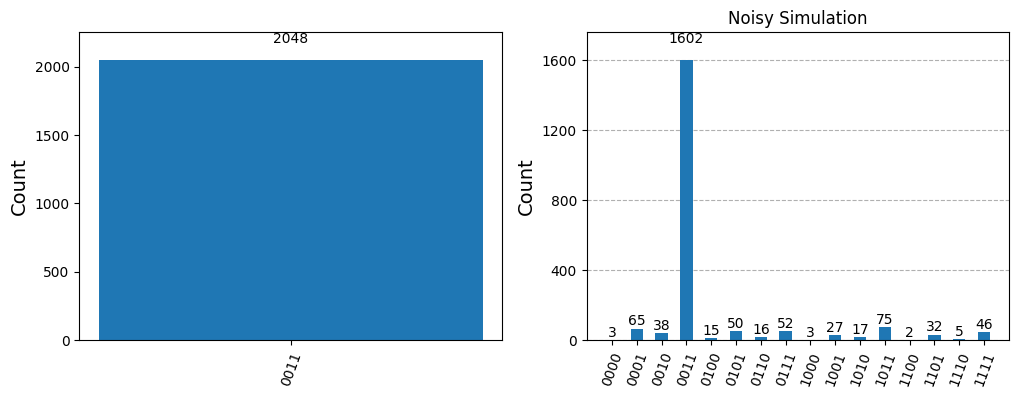

Expected phase (θ): 0.375
Ideal most frequent output: 0011
Noisy most frequent output: 0011


In [29]:
# --- Task 5: Noise Simulation using Qiskit Aer NoiseModel (Qiskit ≥1.0 compatible) ---

from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel, depolarizing_error, thermal_relaxation_error
from qiskit.visualization import plot_histogram
import numpy as np
import matplotlib.pyplot as plt

# --- Reuse Inverse QFT ---
def inv_qft(qc, n):
    for j in range(n // 2):
        qc.swap(j, n - j - 1)
    for j in range(n):
        for m in range(j):
            qc.crz(-np.pi / (2 ** (j - m)), m, j)
        qc.h(j)

# --- QPE circuit function ---
def qpe_circuit(theta, t_count):
    qc = QuantumCircuit(t_count + 1, t_count)
    for q in range(t_count):
        qc.h(q)
    qc.x(t_count)
    for j in range(t_count):
        angle = 2 * np.pi * theta * (2 ** j)
        qc.crz(angle, j, t_count)
    inv_qft(qc, t_count)
    qc.barrier()
    qc.measure(range(t_count), range(t_count))
    return qc

# --- Step 1: Define simulation parameters ---
theta = 0.375
t_count = 4
shots = 2048

# --- Step 2: Build the ideal circuit ---
qc_ideal = qpe_circuit(theta, t_count)

# --- Step 3: Define a basic noise model ---
noise_model = NoiseModel()

# Depolarizing error for single- and two-qubit gates
single_qubit_error = depolarizing_error(0.01, 1)
two_qubit_error = depolarizing_error(0.03, 2)

# Add them to the model
noise_model.add_all_qubit_quantum_error(single_qubit_error, ['h', 'x', 'rz'])
noise_model.add_all_qubit_quantum_error(two_qubit_error, ['crz'])

# --- Step 4: Create simulators ---
sim_ideal = AerSimulator()
sim_noisy = AerSimulator(noise_model=noise_model)

# --- Step 5: Transpile and run both versions ---
compiled_ideal = transpile(qc_ideal, sim_ideal)
compiled_noisy = transpile(qc_ideal, sim_noisy)

result_ideal = sim_ideal.run(compiled_ideal, shots=shots).result()
result_noisy = sim_noisy.run(compiled_noisy, shots=shots).result()

counts_ideal = result_ideal.get_counts()
counts_noisy = result_noisy.get_counts()

# --- Step 6: Compare histograms ---
fig, ax = plt.subplots(1, 2, figsize=(12, 4))
plot_histogram(counts_ideal, title="Ideal Simulation", ax=ax[0])
plot_histogram(counts_noisy, title="Noisy Simulation", ax=ax[1])
plt.show()

# --- Step 7: Print comparison ---
ideal_top = max(counts_ideal, key=counts_ideal.get)
noisy_top = max(counts_noisy, key=counts_noisy.get)

print(f"Expected phase (θ): {theta}")
print(f"Ideal most frequent output: {ideal_top}")
print(f"Noisy most frequent output: {noisy_top}")